In [1]:
#Load data

import pandas as pd
import numpy as np

train_path = "../data/processed/df_train_data_cleaned.csv"
val_path   = "../data/processed/df_validation_data_cleaned.csv"
test_path  = "../data/processed/df_test_data_cleaned.csv"

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

for df in [df_train, df_val, df_test]:
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")

df_train.shape, df_val.shape, df_test.shape


((7487, 16), (1841, 17), (1830, 15))

In [2]:
#missing values:

df_train.isna().sum().sort_values(ascending=False).head(10)


Datum                          0
KielerWoche_kiwo               0
Bewoelkung_weather             0
Temperatur_weather             0
Windgeschwindigkeit_weather    0
Warengruppe_umsatz             0
Umsatz_umsatz                  0
umsatz_rolling7                0
day_of_week                    0
is_saturday                    0
dtype: int64

In [3]:
#All values must be numbers

for df in [df_train, df_val, df_test]:
    df["Warengruppe_umsatz"] = df["Warengruppe_umsatz"].astype(int).astype(str)


In [4]:
target = "Umsatz_umsatz"

X_train = df_train.drop(columns=[target, "Datum"])
y_train = df_train[target].astype(float)

X_val = df_val.drop(columns=[target, "Datum"])
y_val = df_val[target].astype(float)

X_test = df_test.drop(columns=["Datum"])


In [5]:
for df in [X_train, X_val, X_test]:
    df["Warengruppe_umsatz"] = df["Warengruppe_umsatz"].astype(int).astype(str)


In [ ]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0

missing_cols_val = set(X_train.columns) - set(X_val.columns)
for c in missing_cols_val:
    X_val[c] = 0

X_val  = X_val[X_train.columns]
X_test = X_test[X_train.columns]


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = ["Warengruppe_umsatz"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

X_train_p.shape, X_val_p.shape, X_test_p.shape


((7487, 19), (1841, 19), (1830, 19))

In [8]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_p.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early],
    verbose=1
)


2025-12-30 17:35:40.469113: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-30 17:35:40.469478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-30 17:35:40.515288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-30 17:35:41.681981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Epoch 1/200


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
2025-12-30 17:35:42.146195: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51586.0703 - mae: 176.3275 - val_loss: 14041.5723 - val_mae: 85.1353
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7902.0088 - mae: 59.6902 - val_loss: 3214.8376 - val_mae: 39.7340
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3847.9875 - mae: 39.3349 - val_loss: 2581.6152 - val_mae: 34.0568
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3528.2241 - mae: 36.6426 - val_loss: 2400.9055 - val_mae: 32.1735
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3361.3777 - mae: 34.9983 - val_loss: 2285.3616 - val_mae: 30.9541
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3239.1458 - mae: 33.8271 - val_loss: 2203.2996 - val_mae: 30.1239
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3144.4338 - mae: 32.9623 - val_loss: 2142.7080 - val_mae: 29.4975
Epoch 8/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3065.7444 - mae: 32.2408 - val_loss: 2095.0813 - val_mae: 2

In [9]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

pred_val = model.predict(X_val_p).ravel()
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2 = r2_score(y_val, pred_val)

print("Validation RMSE:", rmse)
print("Validation R2:", r2)


 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation RMSE: 42.825049294609244
Validation R2: 0.8916063941609279


In [11]:
print(f"NN Baseline (64-32) | Val R2 = {r2:.4f} | Val RMSE = {rmse:.2f}")


NN Baseline (64-32) | Val R2 = 0.8916 | Val RMSE = 42.83


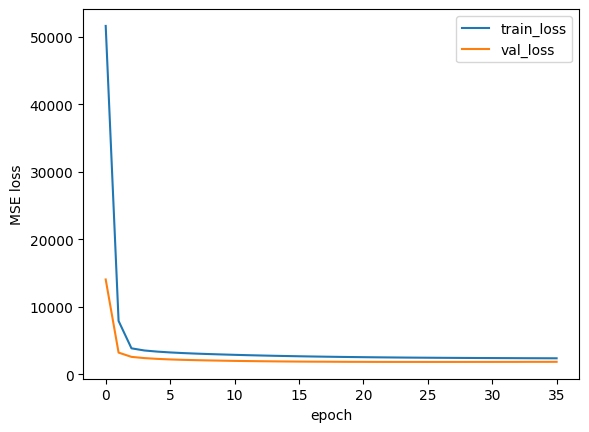

In [10]:
#overdrifting test 

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show()


In [12]:
model.save("../data/processed/nn_baseline.keras")


In [13]:
from tensorflow import keras
model = keras.models.load_model("../data/processed/nn_baseline.keras")


In [14]:
#prediction 

pred_test = model.predict(X_test_p).ravel()
pred_test[:5]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([95.54787 , 81.56737 , 79.41545 , 48.229977, 95.27456 ],
      dtype=float32)

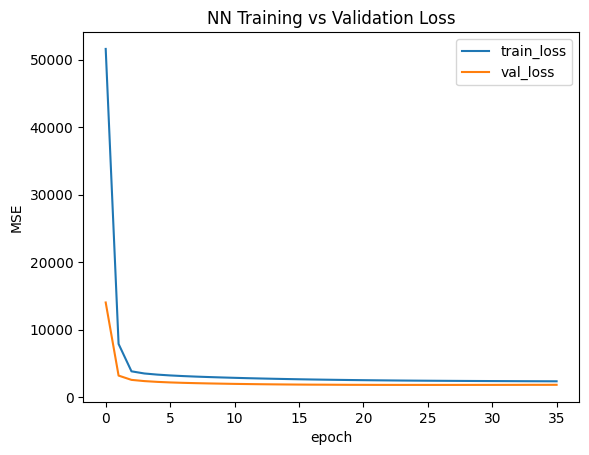

In [16]:
#plot loss curve:

import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("NN Training vs Validation Loss")
plt.show()


In [15]:
#submission 

pred_test = model.predict(X_test_p).ravel()

submission = df_test[["id"]].copy()
submission["Umsatz"] = pred_test
submission.to_csv("../data/processed/submission_nn.csv", index=False)

submission.head()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,id,Umsatz
0,1808011,95.547867
1,1808012,81.567368
2,1808013,79.415451
3,1808014,48.229977
4,1808015,95.274559


In [17]:
print("Test rows:", df_test.shape[0])
print("Submission rows:", submission.shape[0])
print(submission.isna().sum())


Test rows: 1830
Submission rows: 1830
id        0
Umsatz    0
dtype: int64
